### Modelo Pronóstico Oceanic Niño Index (ONI) - Pantaleon Sugar Holdings

Se presenta un modelo de Deep Learning para el pronóstico del valor de Índice Oceánico de El Niño, que representa el índice que traza el patrón climático de la zona océanica ENSO (ver referencias abajo). El ONI es la media móvil trimestral de las anomalías (diferencias respecto a la media) en la superficie de la región centro-oriental tropical del océano Pacífico, cercana a la línea internacional del cambio de fecha.

*   https://ggweather.com/enso/oni.htm
*   https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php

El ONI es importante para categorizar los efectos NIÑO o NIÑA en una escala DÉBIL, MODERADA, FUERTE y MUY FUERTE.

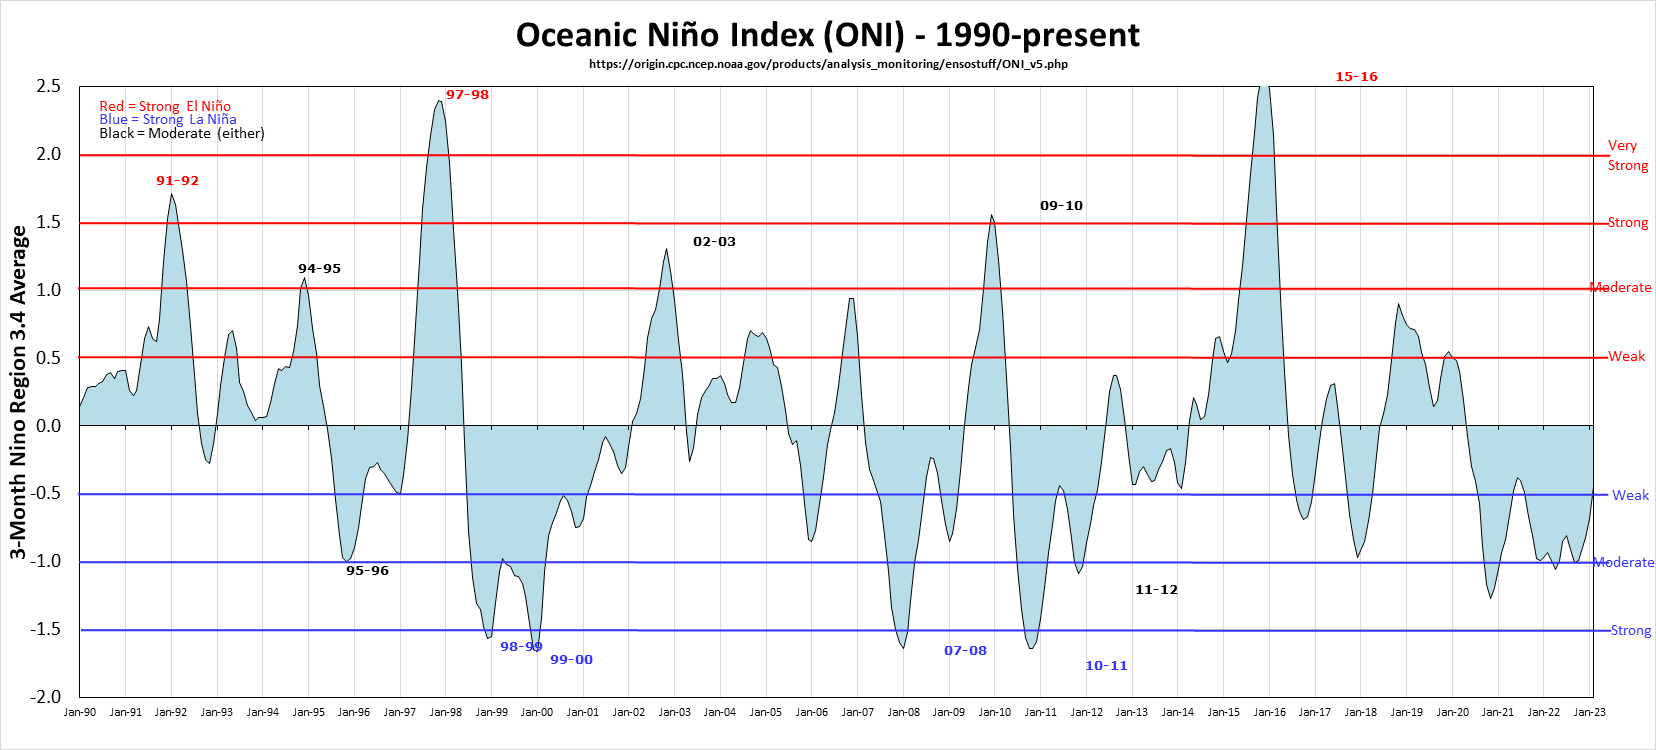


El siguiente trabajo de modelado utiliza una **Red Neuronal Recurrente** para Series de Tiempo, que permite pronosticar futuros valores del ONI por mes. Este modelamiento se realiza sobre los datos registrados del ONI desde el año 1950 por el *National Weather Service* del Centro de Predicción Climática (CPC) de los Estados Unidos.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv(r'drive/MyDrive/Colab Notebooks/LSTMData/ONI_timeseries.csv')
df.head()

,Date,ONI
0,1950-01,-1.5
1,1950-02,-1.3
2,1950-03,-1.2
3,1950-04,-1.2
4,1950-05,-1.1


### Pre-procesamiento:


*   Escalamiento por Máximo y Mínimo (0-1)
*   Armado de Secuencias Cortas para Entrenamiento
*   Separación del Dataset en Entrenamiento y Validación


In [4]:
scaler = MinMaxScaler()
# Escalamiento del ONI
ONI = df.ONI.values.reshape(-1, 1)
scaled_ONI = scaler.fit_transform(ONI)

In [5]:
seq_len = 60

def split_into_sequences(data, seq_len):
    n_seq = len(data) - seq_len + 1
    return np.array([data[i:(i+seq_len)] for i in range(n_seq)])

def get_train_test_sets(data, seq_len, train_frac):
    sequences = split_into_sequences(data, seq_len)
    n_train = int(sequences.shape[0] * train_frac)
    X_train = sequences[:n_train, :-1, :]
    y_train = sequences[:n_train, -1, :]
    X_test = sequences[n_train:, :-1, :]
    y_test = sequences[n_train:, -1, :]
    return X_train, y_train, X_test, y_test

x_train, y_train, x_test, y_test = get_train_test_sets(scaled_ONI, seq_len, train_frac=0.9)

### Arquitectura Red Neuronal Recurrente

In [7]:
# Fracción de la entrada a eliminar, para prevenir sobre-ajuste
dropout = 0.2
window_size = seq_len - 1

# Red Neuronal Recurrente tipo LSTM (Long Short Term Memory) de 3 capas secuenciales
model = keras.Sequential()

model.add(
    LSTM(window_size, return_sequences=True, 
         input_shape=(window_size, x_train.shape[-1]))
)

model.add(Dropout(rate=dropout))

# Entrenamiento Bidireccional permite entrenar secuencias hacia adelante y hacia atrás
model.add(
    Bidirectional(LSTM((window_size * 2), return_sequences=True)
)) 

model.add(Dropout(rate=dropout))
model.add(
    Bidirectional(LSTM(window_size, return_sequences=False))
) 

model.add(Dense(units=1))

# Función lineal de activación: La activación es proporcional a la entrada
model.add(Activation('linear'))

### Entrenamiento Red Neuronal

Se utiliza el *error cuadrático medio* como métrica de precisión. El algoritmo optimizador es **Adam (Adaptative Moment Estimation)**. El entrenamiento se realiza sobre 10 épocas sobre todo el dataset, reservando 20% para validación.

In [8]:
batch_size = 16

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.2
)

Epoch 1/10
37/37 [==============================] - 22s 276ms/step - loss: 0.0404 - val_loss: 0.0374
Epoch 2/10
37/37 [==============================] - 12s 327ms/step - loss: 0.0290 - val_loss: 0.0353
Epoch 3/10
37/37 [==============================] - 10s 269ms/step - loss: 0.0241 - val_loss: 0.0258
Epoch 4/10
37/37 [==============================] - 8s 220ms/step - loss: 0.0180 - val_loss: 0.0211
Epoch 5/10
37/37 [==============================] - 10s 259ms/step - loss: 0.0130 - val_loss: 0.0141
Epoch 6/10
37/37 [==============================] - 10s 266ms/step - loss: 0.0108 - val_loss: 0.0114
Epoch 7/10
37/37 [==============================] - 8s 208ms/step - loss: 0.0092 - val_loss: 0.0097
Epoch 8/10
37/37 [==============================] - 10s 267ms/step - loss: 0.0079 - val_loss: 0.0087
Epoch 9/10
37/37 [==============================] - 8s 209ms/step - loss: 0.0065 - val_loss: 0.0067
Epoch 10/10
37/37 [==============================] - 10s 270ms/step - loss: 0.0053 - val_loss:

### Resultados de Entrenamiento
Métricas de Error en Conjuntos de Entrenamiento y Validación, basadas en RMSE.

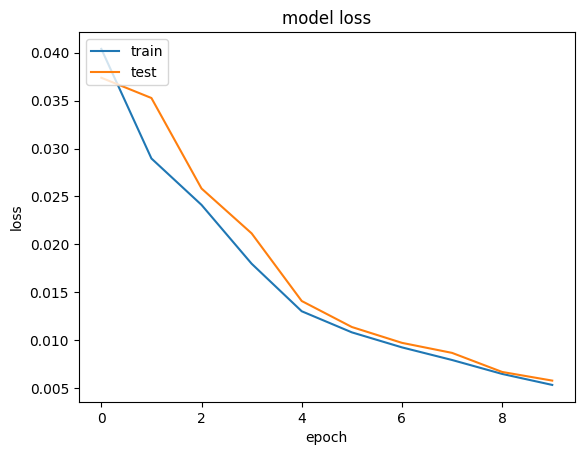

In [15]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Pronósticos sobre ONI

Se realizan predicciones sobre 80 meses en el futuro (conjunto de validación).

3/3 [==============================] - 0s 85ms/step


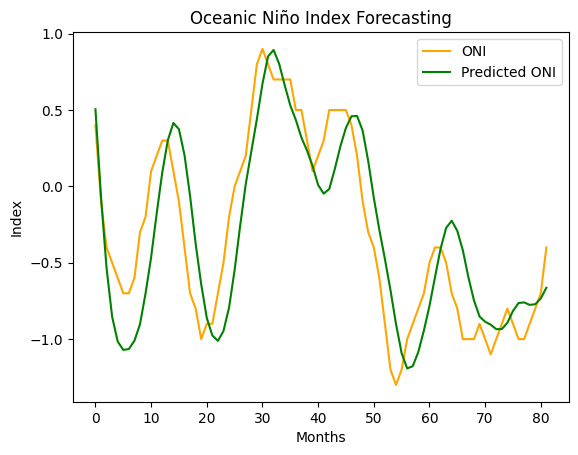

In [36]:
y_pred = model.predict(x_test)

# invert the scaler to get the absolute price data
y_test_orig = scaler.inverse_transform(y_test)
y_pred_orig = scaler.inverse_transform(y_pred)


# plots of prediction against actual data
plt.plot(y_test_orig, label='ONI', color='orange')
plt.plot(y_pred_orig, label='Predicted ONI', color='green')
 
plt.title('Oceanic Niño Index Forecasting')
plt.xlabel('Months')
plt.ylabel('Index')
plt.legend(loc='best')

plt.show();

### Backcasting
Resultados de pronóstico sobre datos históricos (fidelidad del modelo sobre datos registrados en el pasado).

24/24 [==============================] - 2s 88ms/step


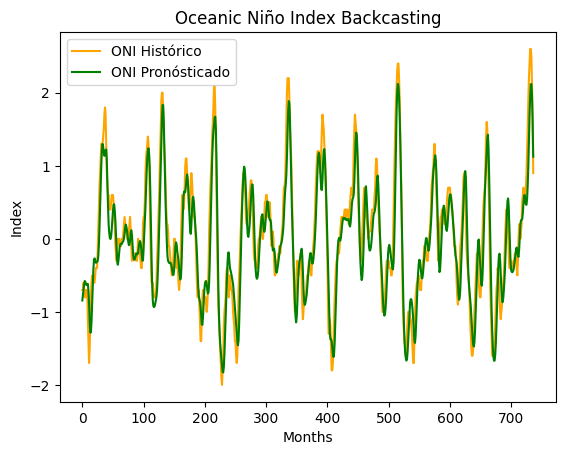

In [37]:
y_pred_train = model.predict(x_train)

# invert the scaler to get the absolute price data
y_train_orig = scaler.inverse_transform(y_train)
y_pred_train_orig = scaler.inverse_transform(y_pred_train)


# plots of prediction against actual data
plt.plot(y_train_orig, label='ONI Histórico', color='orange')
plt.plot(y_pred_train_orig, label='ONI Pronósticado', color='green')
 
plt.title('Oceanic Niño Index Backcasting')
plt.xlabel('Months')
plt.ylabel('Index')
plt.legend(loc='best')

plt.show();

### Resultados Generales RNN LSTM de 3 Capas

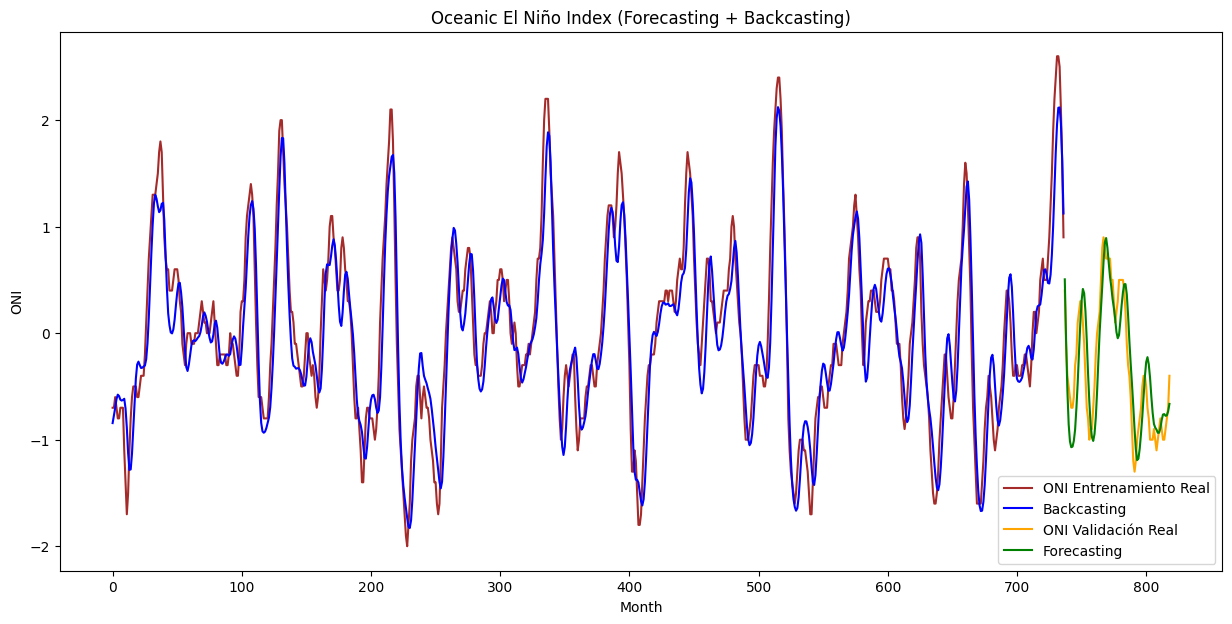

In [38]:
# plot for whole range of data
plt.figure(figsize=(15,7))
plt.plot(np.arange(0, len(y_train)), scaler.inverse_transform(y_train), color='brown', label='ONI Entrenamiento Real')
plt.plot(np.arange(0, len(y_train)), y_pred_train_orig, color='blue', label='Backcasting')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test_orig)), y_test_orig, color='orange', label='ONI Validación Real')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_pred_orig)), y_pred_orig, color='green', label='Forecasting')



plt.title('Oceanic El Niño Index (Forecasting + Backcasting)')
plt.xlabel('Month')
plt.ylabel('ONI')
plt.legend()
plt.show();